# Supervised machine learning: Decision Trees and optimization
## Multi-class classification with text data

## Outline

* [Load and inspect dataset](#dataset)
    * [Import modules](#import)
    * [Read and inspect data](#dataset)
    * [Preprocess data](#preprocess)
    * [Vectorization](#vectorize)
    * [Divide data into training and test sets](#split)
* [More classification with supervised machine learning](#supervised)
    * [Train decision tree model](#model)
    * [More model evaluation](#evaluate)
    * [Cross-validation](#cv)
    * [Optimize parameters with grid search](#gridsearch)
    * [Train and optimize Random Forest model](#RF)

# Data preparation<a id='preparation'></a>

## Import modules<a id='import'></a>

In [89]:
import os
import re
import numpy as np
import pandas as pd
import warnings
import graphviz
from sklearn.tree import export_graphviz
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

#set options
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()
%matplotlib inline

#scikit-learn is a huge library. We import what we need.
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, train_test_split #sklearn utilities
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #For model evaluation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #Vectorizers
from sklearn.linear_model import LogisticRegressionCV #Logit with cross-validation
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #Random Forest and AdaBoost classifiers
from sklearn.tree import DecisionTreeClassifier, plot_tree #Decision Tree classifier
from sklearn.svm import LinearSVC #Linear Support Vector classifier
from sklearn import tree

## Read and inspect dataset<a id='dataset'></a>

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). Note that this is a nice clean dataset--not the norm in real-life data science, but it lets us focus on text classification rather than preprocessing.

In [91]:
df = pd.read_csv('../public_data/crowdflower_tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

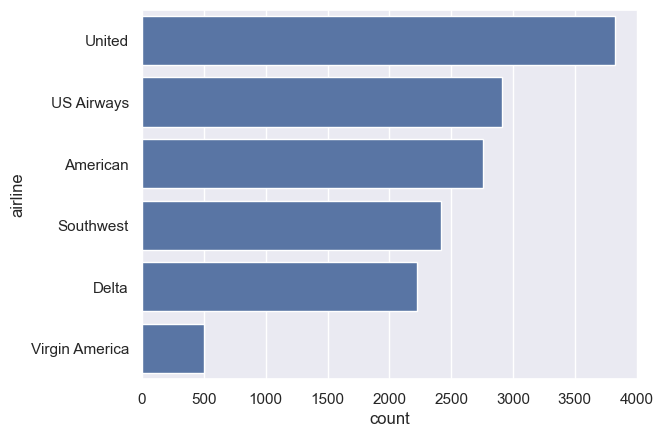

In [93]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index)
plt.show()

Let's get to know the data:

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- What are the main reasons why people are tweeting negatively? 

To visualize counts, this time let's use the `sns.countplot()` function. To visualize proportions, we'll use the `.plot(kind='bar')` method.

In [95]:
print("Length is", len(df))

df['airline_sentiment'].value_counts()

Length is 14640


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [97]:
df['airline_sentiment'].value_counts(normalize=True)

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: proportion, dtype: float64

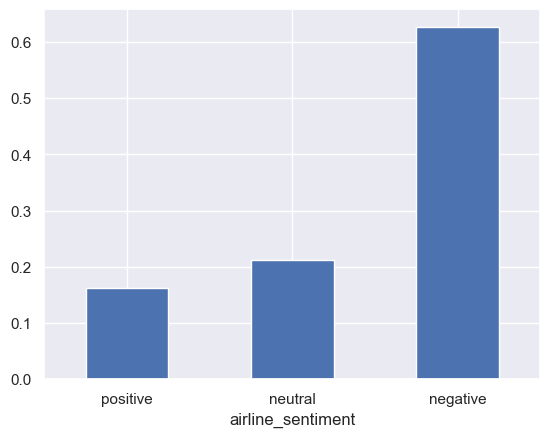

In [99]:
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0)
plt.show()

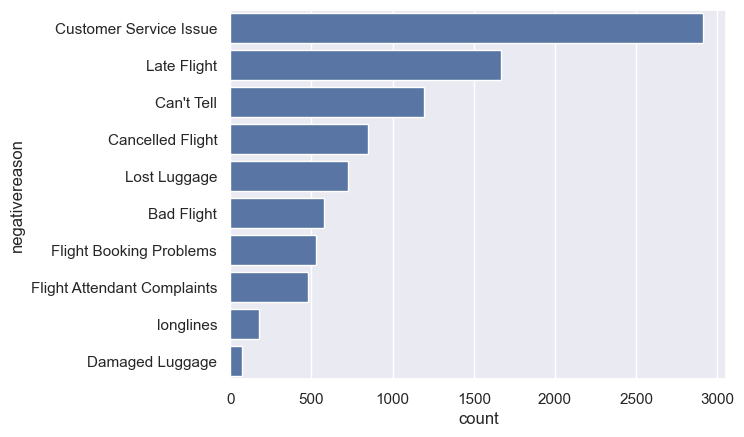

In [101]:
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
#plt.xticks(rotation=90);

plt.show()

## Preprocess data<a id='preprocess'></a>

How are we going to turn our tweets into numbers? First, let's do some quick preprocessing to remove usernames, hashtags, and URLs. Let's assume we don't need any of this information, so removing such junk will sharpen the signal of the text itself.

In [103]:
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'

def clean_tweet(tweet):
    tweet = re.sub(hashtag_pattern, ' HASHTAG', tweet) 
    tweet = re.sub(twitter_handle_pattern, 'USER', tweet)
    return re.sub(url_pattern, 'URL', tweet)

# test function on toy tweets
my_tweets = ["lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo",
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

for tweet in my_tweets:
    print(clean_tweet(tweet))

lol USER and USER are like soo HASHTAG HASHTAG saw it on URL HASHTAG
omg I am never flying on Delta again
I love USER so much HASHTAG


In [105]:
# apply function to DF 
df['clean_text'] = (df['text'].apply(clean_tweet))
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),USER What USER said.
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),USER plus you've added commercials to the expe...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),USER I didn't today... Must mean I need to tak...


## Vectorization<a id='vectorization'></a>

Now that we've cleaned the text, we turn the text into numbers for our classifier. As we did last class, we will use `scikit-learn`'s `CountVectorizer` and a "bag of words" approach to create our features: frequency counts of all the words that appear in a text. 

In [107]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df['clean_text'])
features = X.toarray() # convert matrix to sparse format for easy modeling
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
response = df['airline_sentiment'].values # corresponds to entries in `features` 
response

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

In [111]:
# get feature names (from vectorizer) and label names, will be useful later
feature_names = countvectorizer.get_feature_names_out()
label_names = list(set(response))
print("Labels:", label_names)
print()
print("A few features:", feature_names[500:510])

Labels: ['neutral', 'negative', 'positive']

A few features: ['answer' 'answered' 'answering' 'answers' 'anthony' 'anticipate'
 'antonio' 'anxious' 'any' 'any1']


## Divide data into training and test sets<a id='split'></a>

As we did last class, let's split our data into training and test sets. _Unlike_ last class, we will use a shortcut to create this split: the useful `train_test_split()` function from `scikit-learn`. We will also balance the outcome variable (sentiment) between our training and test samples. 

We'll train on 80% of the data and test the model's accuracy on the rest. An 80/20 split is typical in machine learning tasks; according to the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle), this ratio allows for efficiency and occurs in nature as well as in business, computing, and economics. 

In [113]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, stratify = df.airline_sentiment)

X_train.shape, X_test.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

Now that we've split our data up into `train` and `test` sets, let's look to see how the output variable is distributed within the two datasets.

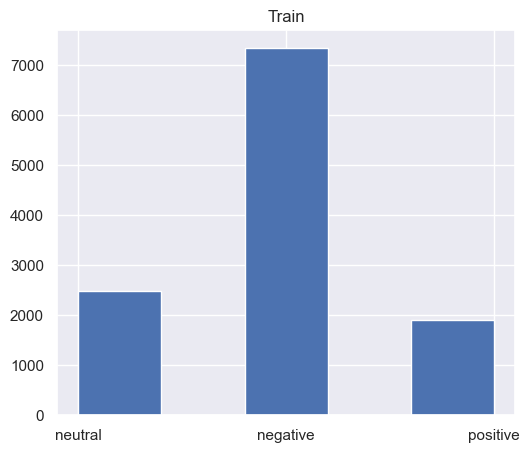

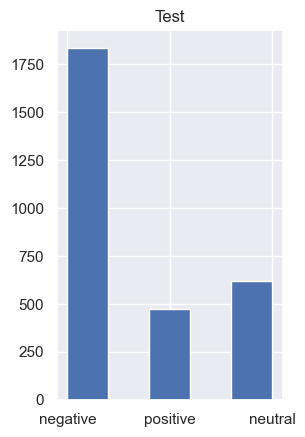

In [115]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1) # shows separate plot on left 
plt.hist(y_train, bins=5)
plt.title('Train')
plt.show()

plt.subplot(1,2,2) # shows separate plot on right
plt.hist(y_test, bins=5);
plt.title('Test')
plt.show();

## the idea of stratification i smaking sure you have 80/20 splits on all of these categories

The three possible values of the output variable (sentiment) appear more or less equally distributed across the training and test datasets, which matters for model performance. (If they weren't, we could use the `stratify` parameter of `sklearn`'s `train_test_split()` method to split them equally.)

# More classification with supervised machine learning<a id='supervised'></a>

## Train decision tree model<a id='model'></a>

In [117]:
# Initialize decision tree model using scikit-learn
dt_classifier = DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                                       splitter='best',  # or 'random' for random best split
                                       max_depth=10,  # how deep tree nodes can go
                                       min_samples_split=5,  # samples needed to split node
                                       min_samples_leaf=10,  # samples needed for a leaf
                                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                       max_features=None,  # number of features to look for when splitting
                                       max_leaf_nodes=None,  # max nodes
                                       min_impurity_decrease=1e-07, #early stopping
                                       random_state = 10) #random seed

dt_classifier.fit(X_train, y_train) # fit model on training set

DecisionTreeClassifier(max_depth=10, min_impurity_decrease=1e-07,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=10)

An advantage of decision tree models is that they are easy to visualize. Let's look at the top four levels of the tree we just built, which show the decision rules the algorithm learned from features to determine the labels. The top part of each bubble indicates the feature being checked for that decision node; for instance, a node checking for $thank <= 0.5$ registers as $True$ when this word is absent and $False$ when the word occurs at least once. In either case, that case may go down another branch and be checked further at later nodes, creating a potential complex of conditions. 

'gini' refers to the importance of the feature; the higher this value, the more important that feature is for determinining the associated label. 'samples' shows the number of cases that reach that node, while 'class' indicates the label assigned for cases that stop at that decision node. 

In [119]:
dt_data = export_graphviz(dt_classifier, 
                          out_file=None, 
                          feature_names=feature_names,  
                          class_names=y_train,
                          max_depth=4,
                          filled=True, 
                          rounded=True,  
                          special_characters=True)  

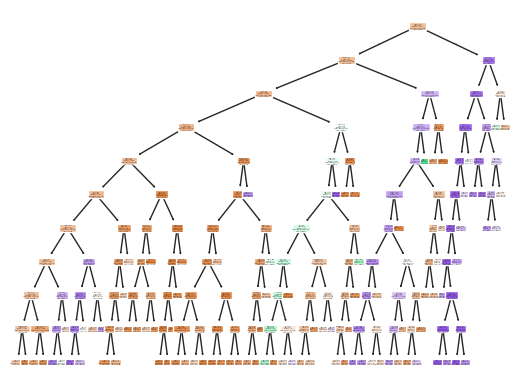

In [121]:
tree.plot_tree(dt_classifier, 
                   feature_names=feature_names,  
                   class_names=label_names,
                   filled=True, )
print("")
plt.show()

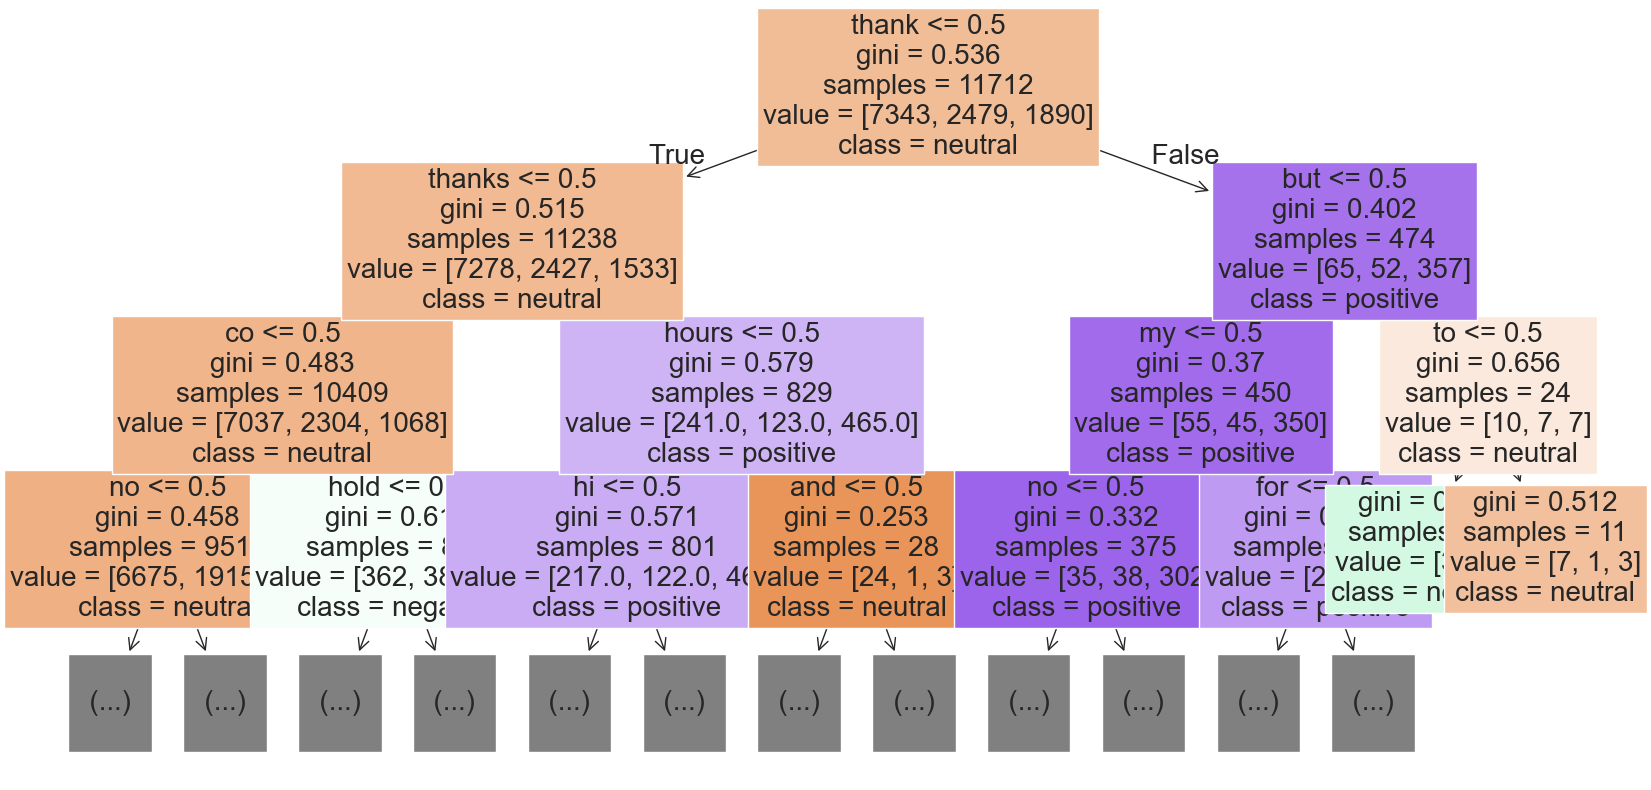

In [123]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt_classifier, 
                   feature_names=feature_names,  
                   class_names=label_names,
                   filled=True, max_depth=3,fontsize=20,
      )
print("")
plt.show()

To test model performance, we can use either `accuracy_score()` or the built-in `score` method to return the mean accuracy. Either method can be used on both the train and test datasets. Let's check the in-sample accuracy of the model on the training data:

In [125]:
#predict the labels on the training set using the trained model
predictions_dt = dt_classifier.predict(X_train) 

accuracy_score(predictions_dt, y_train)

0.7070525956284153

That's an excellent score! Unfortunately, it results from **overfitting**--using the same data for model training as for evaluation. To get a better sense of how our model would generalize to unseen data, let's evaluate the performance of this model using the test data:

In [127]:
# Let's use the built-in `model.score()` method instead this time, results are same as for `accuracy_score()`
print(dt_classifier.score(X_test, y_test))

0.7015027322404371


Not quite perfect, but more realistic and still good!

### IN-CLASS CHALLENGE 1: Predict labels on unseen data

Use the Decisition Tree model you just built to predict the label for three unlabeled reviews. Predict both the label and the probability of being in each category. Do the predictions make sense? Do the probabilities provide any useful information beyond the predicted labels?

_Hint:_ Remember to use `countvectorizer()` and convert to sparse format with `.toarray()` to vectorize the texts prior to prediction. Use `model.predict()` to predict the class and `model.predict_proba()` to predict class probabilities.

In [129]:
careless_review = "I made my flight reservation with UnitedAirlines and the service is ridiculous and they just bluntly \
deny solving your problem. I booked my flight but they were having some technical issues and didn't appear \
in their system. United customer service just said they can not do anything and asked me to book a new ticket to fly. \
This is just insane and troubling and also really costly at the airport. Thus, I made my flight reservation \
with United Airlines for the next day through an online flight booking portal that offered much cheaper flights. \
You can contact them over the phone by calling a toll-free number +1-888-720-1433 and book flights that are light \
on your pocket."

good_review = "United was very accommodating for our vacation recently and even got us home a little quicker. \
We were travelling in a group of 12 coming home from a vacation and because of storms back east our connecting flight \
was delayed by hours. Knowing this was completely out of their control we started talking with one of the United \
employees and told them where we were headed. She said she could get us on a flight that actually leaves earlier \
than our original flight. It was such great service and resulted in all of us getting home hours later. The only \
issue was our bags, but United had them delivered to our homes that next morning."

canceled_review = "Canceled my trip twice, the first time I received no notification. The second time I got a notice \
that one of my trips may have been canceled or changed, the website didn’t say which it was. It instructed me to cancel \
it myself. Probably so they could avoid having to refund me. Now I all the money I spent on tickets sitting in a United \
account but I never want to fly with them in the future so that’s a nice chunk of about $2000 wasted. \
EDIT: After I cancelled my second trip I was able to select an option for refund, the refund was not only \
for the second trip but also my first trip that was cancelled earlier. I will upgrade the rating from 1 to 3 stars \
would have given higher with better customer service/website service/website information."

In [151]:
# solution
# Transform these into DTMs with the same feature-columns as previously
unknown_dtm = countvectorizer.transform(
    [careless_review, good_review, canceled_review]).toarray()

unknown_dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [153]:
## your code here

## HERE --> the model already exists (it is called dt_classifier) and you are using it to run predictions and probabilities on these three you have

predicted_labels = dt_classifier.predict(unknown_dtm)
print("Predicted Classes:" )
predicted_labels



Predicted Classes:


array(['negative', 'positive', 'negative'], dtype=object)

In [155]:
predicted_proba = dt_classifier.predict_proba(unknown_dtm)
print(f"Predicted Probabilities for each review\n(order: {dt_classifier.classes_}):" )
predicted_proba

Predicted Probabilities for each review
(order: ['negative' 'neutral' 'positive']):


array([[0.87188612, 0.09489917, 0.03321471],
       [0.25      , 0.08333333, 0.66666667],
       [0.75      , 0.17857143, 0.07142857]])

## Cross-validation<a id='cv'></a>

Dividing our labeled data into a single set of training and test data gives a limited picture of how our algorithm performs on unseen data. Ideally, we would want a lot of unseen data to test our model on, to reduce the risk that the test data we selected (even if randomly) is unusually similar to or different from the training data in terms of structure. How can we use our limited labeled data to get a better sense of the accuracy of a trained model? 

This is where **cross-validation** comes in. One way to do this is to keep an additional set of test data from model training AND testing (called _held-out test set_ and usually differentiated from a _validation set_), and only to use it for evaluation after model construction is finalized. However, this leaves even less data available for model training, which can result in **underfitting**. 

$K$-fold cross-validation can be easily implemented using `scikit-learn`'s `cross_val_score()` function:

In [137]:
scores = cross_val_score(dt_classifier, X_train, y_train, cv=3)
scores   

array([0.68878074, 0.69697746, 0.69390369])

In [139]:
# Show average accuracy across folds along with sigma (std. squared)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.6932 (+/- 0.0068)


Why is the cross validation accuracy different than our classifier? Which estimate is more accurate?

## More model evaluation <a id="evaluate"></a>

One of the most useful layouts to observe model performance is a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), a table layout showing the relationships between predicted, true, and condition positives and negatives. Columns show predicted outcomes, while rows show ground truth. First let's look at the raw output of `scikit-learn`'s `confusion_matrix()` method.

In [157]:
confusion_matrix(y_test, dt_classifier.predict(X_test))

## confusion matrices help you see hte types of errors you have very clearly

array([[1735,   37,   63],
       [ 489,   87,   44],
       [ 217,   24,  232]])

This is a little hard to interpret, so let's make a prettier table to show model performance on the test set.

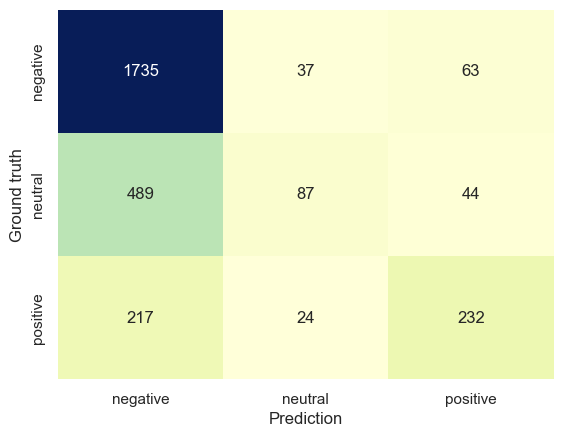

In [159]:
model = dt_classifier # change this one line to visualize confusion matrix for other models
y_predict = model.predict(X_test) 
labels = model.classes_
conmat = confusion_matrix(y_test, y_predict)

sns.heatmap(conmat, 
            annot=True, 
            fmt='d', 
            xticklabels=labels, 
            yticklabels=labels, 
            cmap="YlGnBu", 
            cbar=False)
plt.ylabel('Ground truth')
plt.xlabel('Prediction')

plt.show()


## HEAT MAPS AND CONFUSION MATRICES ARE THE FIRST HTIGNS YOU SHOULD DO WHEN YOU DO A MODEL TO SEE HOW GOOD IT IS

That's better, but what about the different metrics to convey all this information? Above we looked at accuracy, but `scikit-learn` can also print out a lot more information--including the **precision** and **recall** scores for each outcome--of a classification model with the `classification_report()` method.

In [161]:
dt_predicted = dt_classifier.predict(X_test)
print("Classification report:")
print(classification_report(y_test, dt_predicted)) 

Classification report:
              precision    recall  f1-score   support

    negative       0.71      0.95      0.81      1835
     neutral       0.59      0.14      0.23       620
    positive       0.68      0.49      0.57       473

    accuracy                           0.70      2928
   macro avg       0.66      0.53      0.54      2928
weighted avg       0.68      0.70      0.65      2928



## Optimize parameters with grid search <a id="gridsearch"></a>

Optimizing model parameters is one of the most important steps in building a supervised machine learning model. One way to do this is by using what's called a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). A grid search tests different possible parameter combinations to see which combination yields the most accurate predictions. Fortunately, `scikit-learn` makes this very easy to do with the `GridSearchCV()` function. 

Here we'll see what is the best combination of the parameters `min_samples_split` and `min_samples_leaf` for building a decision tree model to predict user sentiment in our airline reviews dataset. We can make a dictionary with the names of the parameters as the keys and the range of values as the corresponding values.

In [163]:
# Grid searching is computationally expensive, so for time's sake we'll test a minimal range for each parameter
# In real-world data analytics there would be a much larger range, making exponentially more permutations (and time cost)

param_grid = {'min_samples_split': [2,10], # define dictionary with possible model parameters
              'min_samples_leaf': [2,10]}

param_grid

{'min_samples_split': [2, 10], 'min_samples_leaf': [2, 10]}

Then we can implement the grid search and fit our model according to the best parameters.

In [165]:
# Warning: This can take a long time!
model_dt = GridSearchCV(dt_classifier, 
                        param_grid, 
                        cv=3, 
                        return_train_score=True)

model_dt.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=10,
                                              min_impurity_decrease=1e-07,
                                              min_samples_leaf=10,
                                              min_samples_split=5,
                                              random_state=10),
             param_grid={'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10]},
             return_train_score=True)

To see what are the model parameters to produce the highest accuracy on the training set, we will find the maximum `mean_train_score` and its associated parameter values:

In [167]:
# Get information on model parameters that perform best
model = model_dt # Change this to visualize other models

# Get index of best model parameters
best_index = np.argmax(
    model.cv_results_["mean_train_score"]
                      )

print('Best parameter values are:', 
      model.cv_results_["params"][best_index]
     )
print('Best mean cross-validation train accuracy: %.03f' % 
      model.cv_results_["mean_train_score"][best_index]
     )
print('Overall mean test accuracy: %.03f' % 
      model.score(X_test, y_test)
     )


Best parameter values are: {'min_samples_leaf': 2, 'min_samples_split': 2}
Best mean cross-validation train accuracy: 0.722
Overall mean test accuracy: 0.702


## Train and optimize Random Forest model <a id="RF"></a>

Now we'll look at [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a more complex method that pools decision tree classifiers and averages their results to improve accuracy and reduce overfitting. Each decision tree is fit to a subset of the data (bagging), and uses only a subset of the features (random subspace). Random forests are an example of _ensemble methods_, which pool results from many simpler classifiers. 

In [169]:
rf_classifier = RandomForestClassifier(n_estimators=10,  # number of trees
                       criterion='gini',  # or 'entropy' for information gain
                       max_depth=10, )  # adjusts weights inverse of freq, also "balanced_subsample" or None

rf_model = rf_classifier.fit(X_train, y_train) # fit model on training data

Let's look at the classification performance on the test data:

In [171]:
print("Accuracy of Random Forest model (with 3-fold CV) with test data defined above:")
scores = cross_val_score(rf_model, X_test, y_test, cv=3)
print("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) # Show average accuracy across folds
print()

predicted = rf_model.predict(X_test)
print("Classification report:")
print(classification_report(y_test, predicted)) 
print()


## this ends up doing worse--> just bc a model is more complex doesnt mean it is better

Accuracy of Random Forest model (with 3-fold CV) with test data defined above:
0.6301 (+/- 0.0073)

Classification report:
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1835
     neutral       0.70      0.01      0.02       620
    positive       1.00      0.00      0.00       473

    accuracy                           0.63      2928
   macro avg       0.78      0.34      0.27      2928
weighted avg       0.70      0.63      0.49      2928




### IN-CLASS CHALLENGE 2: Grid Search on Random Forest

Do another grid search to determine the best parameters for the Random Forest we just created. Use two possible levels for `min_samples_split` and `min_samples_leaf`, each between 5 and 20. 

In [201]:
# your code here

param_grid2 = {'min_samples_split': [5,20], # define dictionary with possible model parameters
              'min_samples_leaf': [5,20]}

param_grid2


# Warning: This can take a long time!
rf_model = GridSearchCV(RandomForestClassifier(n_estimators = 10,
                                               max_depth = 10,
                                               min_impurity_decrease = 1e-07,
                                               random_state = 10,
                                               class_weight = "balanced_subsample"),
                        param_grid2, 
                        cv=3, 
                        return_train_score=True)

rf_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              max_depth=10,
                                              min_impurity_decrease=1e-07,
                                              n_estimators=10,
                                              random_state=10),
             param_grid={'min_samples_leaf': [5, 20],
                         'min_samples_split': [5, 20]},
             return_train_score=True)

In [203]:
rf_model.cv_results_["mean_train_score"]

array([0.66389173, 0.66043374, 0.64779713, 0.64779713])

### IN-CLASS CHALLENGE 3: Adjust text preprocessing

Preprocessing methods matter for machine learning performance: Depending on the algorithm, less or more preprocessing may be better. Let's see how a simple Random Forest model does with minimal preprocessing--without removing usernames, hashtags, or URLs. Compare this model's performance with that of Random Forest trained on cleaned text.

In [205]:
# your code here

## first load in the og data 
df_nopp = pd.read_csv('../public_data/crowdflower_tweets.csv')
#df_nopp.head()

## as your model gets more complex, the more complex of inputs you can feed it.

In [207]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df_nopp["text"])
features = X.toarray() # convert matrix to sparse format for easy modeling
features

X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, stratify = df.airline_sentiment)

X_train.shape, X_test.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

In [209]:
# your code here

param_grid2 = {'min_samples_split': [5,20], # define dictionary with possible model parameters
              'min_samples_leaf': [5,20]}

param_grid2


# Warning: This can take a long time!
rf_model = GridSearchCV(RandomForestClassifier(n_estimators = 10,
                                               max_depth = 10,
                                               min_impurity_decrease = 1e-07,
                                               random_state = 10,
                                               class_weight = "balanced_subsample"),
                        param_grid2, 
                        cv=3, 
                        return_train_score=True)

rf_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              max_depth=10,
                                              min_impurity_decrease=1e-07,
                                              n_estimators=10,
                                              random_state=10),
             param_grid={'min_samples_leaf': [5, 20],
                         'min_samples_split': [5, 20]},
             return_train_score=True)

In [211]:
rf_model.cv_results_["mean_train_score"]

array([0.64280225, 0.6523224 , 0.64156421, 0.64156421])

In [197]:
# rf_classifier = RandomForestClassifier(n_estimators=10,  # number of trees
#                        criterion='gini',  # or 'entropy' for information gain
#                        max_depth=10)  # adjusts weights inverse of freq, also "balanced_subsample" or None

# rf_model = rf_classifier.fit(X_train, y_train) # fit model on training data (THIS IS WHAT TRAINS THE MODEL ON UR TRAINING DATA THAT YOUVE PREVIOUSLY SPLIT INTO)

# print("Accuracy of Random Forest model (with 3-fold CV) with test data defined above:")
# scores = cross_val_score(rf_model, X_test, y_test, cv=3)
# print("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) # Show average accuracy across folds
# print()

# predicted = rf_model.predict(X_test)
# print("Classification report:")
# print(classification_report(y_test, predicted)) 
# print()

Accuracy of Random Forest model (with 3-fold CV) with test data defined above:
0.6346 (+/- 0.0108)

Classification report:
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1835
     neutral       0.83      0.01      0.02       620
    positive       1.00      0.00      0.01       473

    accuracy                           0.63      2928
   macro avg       0.82      0.34      0.27      2928
weighted avg       0.73      0.63      0.49      2928


